In [0]:
# lstm for time series forecasting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0, index_col=0, squeeze=True)
print(df.shape)
df.head()

(108,)


Month
1960-01     6550
1960-02     8728
1960-03    12026
1960-04    14395
1960-05    14587
Name: Sales, dtype: int64

In [66]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = [], []
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return asarray(X), asarray(y)
 
# retrieve the values
values = df.values.astype('float32')
# specify the window size
n_steps = 5
# split into samples
X, y = split_sequence(values, n_steps)
# scale data
sc_X = MinMaxScaler()
X = sc_X.fit_transform(X)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_test = 12
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(91, 5, 1) (12, 5, 1) (91,) (12,)


In [0]:
# define model

inputs = keras.Input(shape=(n_steps, 1))
x = LSTM(64, activation='relu', kernel_initializer='he_normal', return_sequences=True)(inputs)
x = Dropout(rate=0.2)(x)
x = LSTM(64, activation='relu', kernel_initializer='he_normal', return_sequences=True)(x)
x = Dropout(rate=0.2)(x)
x = LSTM(64, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(rate=0.2)(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(32, activation='relu', kernel_initializer='he_normal')(x)
outputs = Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# plot the model
keras.utils.plot_model(model, show_shapes=True)

# fit the model
history = model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=0, validation_data=(X_test, y_test))

In [68]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

MSE: 22989816.000, RMSE: 4794.770, MAE: 4219.321


In [69]:
# make a prediction
row = asarray(sc_X.transform([[18024.0, 16722.0, 14385.0, 21342.0, 17180.0]])).reshape((1, n_steps, 1))
yhat = model.predict(row)
print(yhat)
print('Predicted: %.3f' % (yhat[0]))

[[15365.479]]
Predicted: 15365.479


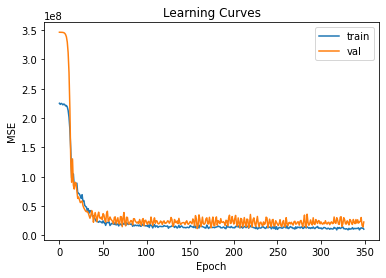

In [70]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()